In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import xarray as xr
# from matplotlib.axes import Axes
# from cartopy.mpl.geoaxes import GeoAxes
import pickle

###
from parcels import Variable, FieldSet, ParticleSet, AdvectionRK4, JITParticle
from parcels import ErrorCode, DiffusionUniformKh, Field
from datetime import timedelta
import datetime

In [8]:
# infile = open('../river_sources.pkl', 'rb')
# river_sources = pickle.load(infile)

In [26]:
smoc = xr.open_dataset('../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc')

In [32]:
parcels_origin = {'Luanda': (-9.3, 13.),
                 'Cuvo': (-10.87917, 13.7),
                 'Paraiba': (-21.6208, -40.9),
                 'Itajai': (-26.9125, -48.5),
                 'Chiloango-Congo': (-5.6442, 12.05),
                 'Cape-Town': (-33.93, 18.2),
                 'Rio-de-la-Plata': (-34.8, -57.2),
                 'Rio-de-Janeiro': (-23.1, -43.32083),
                 'Porto-Alegre': (-32.15, -51.9),
                 'Santos': (-24.15, -46.2958)}

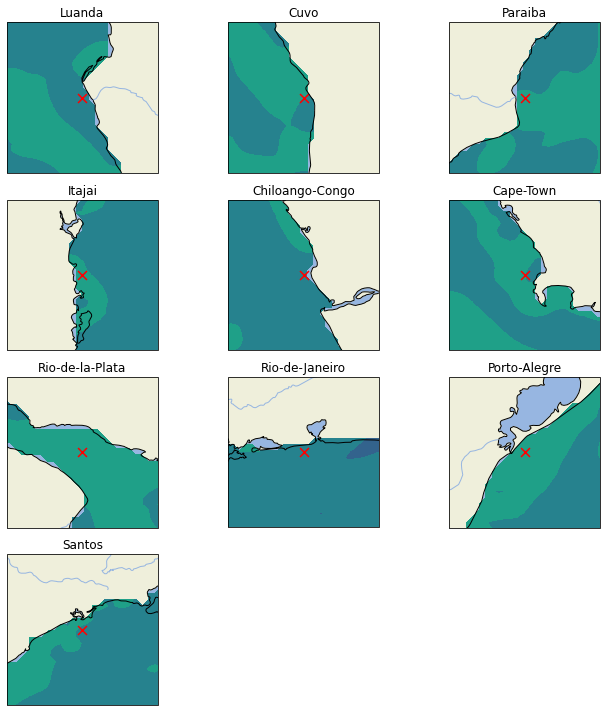

In [33]:
fig,ax = plt.subplots(ncols=3,nrows=4,figsize=(10,10),
                      subplot_kw={'projection': ccrs.PlateCarree()})
r = 1
i = 0
for k, loc in enumerate(parcels_origin):
    j = k%3
    lat_BA, lon_BA = parcels_origin[loc]
    
    ax[i,j].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[i,j].add_feature(cfeature.OCEAN)
    ax[i,j].add_feature(cfeature.LAND)
    ax[i,j].add_feature(cfeature.COASTLINE)
    ax[i,j].add_feature(cfeature.RIVERS)
    ax[i,j].set_title(loc)
    
    ax[i,j].contourf(smoc['longitude'], smoc['latitude'], smoc['uo'][0,0],
             transform=ccrs.PlateCarree())
    ax[i,j].scatter(lon_BA, lat_BA, s=80, marker='x', color='red')
    if j%3 == 2: i+=1 

plt.tight_layout()

ax[3,1].remove()
ax[3,2].remove()

In [35]:
np.save('../river_sources.npy', parcels_origin, allow_pickle=True)

In [37]:
np.load('../river_sources.npy', allow_pickle=True).item()

{'Luanda': (-9.3, 13.0),
 'Cuvo': (-10.87917, 13.7),
 'Paraiba': (-21.6208, -40.9),
 'Itajai': (-26.9125, -48.5),
 'Chiloango-Congo': (-5.6442, 12.05),
 'Cape-Town': (-33.93, 18.2),
 'Rio-de-la-Plata': (-34.8, -57.2),
 'Rio-de-Janeiro': (-23.1, -43.32083),
 'Porto-Alegre': (-32.15, -51.9),
 'Santos': (-24.15, -46.2958)}

-----
## Parcels

In [48]:
def delete_particle(particle, fieldset, time): #indices=indices):
    particle.delete()

def set_diffussion(fieldset):
    size2D = (fieldset.U.grid.ydim, fieldset.U.grid.xdim)

    fieldset.add_field(Field('Kh_zonal', data=K_bar * np.ones(size2D),
                             lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                             mesh='spherical'))
    fieldset.add_field(Field('Kh_meridional', data=K_bar * np.ones(size2D),
                             lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                             mesh='spherical'))
    
def set_landmask(fieldset):
    land_mask = np.load('../landmask.npy')
    fieldset.add_field(Field('land', data=land_mask, 
                       lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                       mesh='spherical'))

class ParticleBeaching(JITParticle):           
    beached = Variable('beached', dtype=np.int32, initial=0)  
    beachcount = Variable('beachcount', dtype=np.int32, initial=0)


In [49]:
n_points = 1000  # particles per sampling site\
n_days = 1  # 22*30  # number of days to simulate
K_bar = 1000  # diffusion value
stored_dt = 1  # hours
loc = 'Rio-de-la-Plata'

data = '../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc'
output_path = f'../data/simulations/source_{loc}_release.nc'

In [50]:
# time range 2018-01-01 to 2019-11-27
filesnames = {'U': data,
              'V': data}

variables = {'U': 'uo',
             'V': 'vo'}  # Use utotal

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}
indices = {'lat': range(1, 900), 'lon': range(1284, 2460)}

fieldset = FieldSet.from_netcdf(filesnames, variables, dimensions,
                                allow_time_extrapolation=True, indices=indices)
set_diffussion(fieldset)
set_landmask(fieldset)

In [52]:
with open('../river_sources.pkl', 'rb') as infile:
    river_sources = pickle.load(infile)

In [53]:
np.random.seed(2)  # to repeat experiment in the same conditions
# Create the cluster of particles around the sampling site
# with a radius of 1/24 deg (?).
time = datetime.datetime.strptime('2018-01-01 12:00:00', '%Y-%m-%d %H:%M:%S')

lon_cluster = [river_sources[loc][1]]*n_points
lat_cluster = [river_sources[loc][0]]*n_points

lon_cluster = np.array(lon_cluster)+(np.random.random(len(lon_cluster))-0.5)/24
lat_cluster = np.array(lat_cluster)+(np.random.random(len(lat_cluster))-0.5)/24
date_cluster = np.repeat(time, n_points)

In [54]:
class SampleParticleInitZero(JITParticle):        
    beaching = Variable('beaching', initial=0, dtype=np.int32)  



pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=SampleParticleInitZero,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             time=date_cluster)

def Saple_landmask(particle, fieldset, time):
         particle.beaching = fieldset.land[time, particle.depth,
                                           particle.lat, particle.lon]
        
sample_kernel = pset.Kernel(Saple_landmask)   

def Beaching(particle, fieldset, time):
    if particle.beaching == 1:
        particle.delete()
        
beaching_kernel = pset.Kernel(Beaching)


In [59]:
# Output file
output_file = pset.ParticleFile(name=output_path,
                                outputdt=timedelta(hours=stored_dt))

# Execute!
pset.execute(pset.Kernel(AdvectionRK4) + DiffusionUniformKh + sample_kernel \
                                       + beaching_kernel,
             runtime=timedelta(days=n_days),
             dt=timedelta(hours=1),
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: delete_particle})

output_file.close()

INFO: Compiled SampleParticleInitZeroAdvectionRK4DiffusionUniformKhSaple_landmaskBeaching ==> /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/8f80a48d81be257e61cc9f595cdd8772_0.so


# Check

In [60]:
particles = xr.load_dataset(f'../data/simulations/source_{loc}_release.nc')
particles

<xarray.Dataset>
Dimensions:     (obs: 25, traj: 1000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 3e+03 3e+03 3e+03 ... 3.999e+03 3.999e+03
    time        (traj, obs) datetime64[ns] 2018-01-01T12:00:00 ... 2018-01-02...
    lat         (traj, obs) float32 -34.29492 -34.319046 ... -34.324314
    lon         (traj, obs) float32 -58.202667 -58.204136 ... -58.253365
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    beaching    (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

In [61]:
particles['lon'].shape

(1000, 25)

In [36]:
particles['beaching'][100,:]

<xarray.DataArray 'beaching' (obs: 25)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Dimensions without coordinates: obs
Attributes:
    long_name:      
    standard_name:  beaching
    units:          unknown

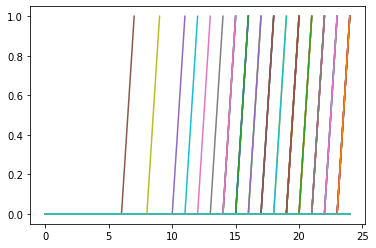

In [62]:
for i in range(1000):
    plt.plot(particles['beaching'][i,:])

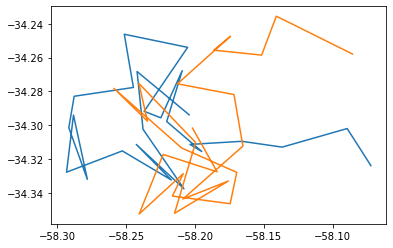

In [63]:
plt.plot(particles['lon'][945,:], particles['lat'][945,:])
plt.plot(particles['lon'][900,:], particles['lat'][900,:])

In [65]:
land_mask = np.load('../landmask.npy')

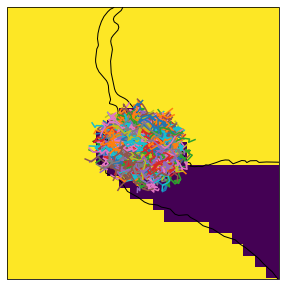

In [66]:
fig = plt.figure(figsize=(5,5))
r = 1
ax = plt.axes(projection=ccrs.PlateCarree())
lat_BA, lon_BA = river_sources[loc]
ax.pcolormesh(smoc['longitude'][indices['lon']], 
              smoc['latitude'][indices['lat']],
              land_mask)
ax.set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())

ax.coastlines()
ax.plot(particles['lon'].T, particles['lat'].T);